In [1]:
# !pip install transformers
# !pip install wandb

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [ ]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2", 
                                                    bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                                                    pad_token='<pad>', mask_token='<mask>')
tokenizer.tokenize("안녕하세요. 한국어 GPT-2 입니다.😤:)l^o")

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")
model = AutoModelForCausalLM.from_pretrained("skt/kogpt2-base-v2")

In [ ]:
import torch

In [ ]:
text = '구'
input_ids = tokenizer.encode(text, return_tensors='pt')
gen_ids = model.generate(input_ids, 
                         max_length=10, 
                         repetition_penalty=2.0, 
                         pad_token_id=tokenizer.pad_token_id,
                         eos_token_id=tokenizer.eos_token_id,
                         bos_token_id=tokenizer.bos_token_id,
                         use_cache=True)

generated = tokenizer.decode(gen_ids[0])
print(generated)

# 여기부터 다른 내용

In [2]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from transformers import PreTrainedTokenizerFast

/opt/conda/lib/python3.8/site-packages/apex/pyprof/__init__.py:5: FutureWarning: pyprof will be removed by the end of June, 2022
  warnings.warn("pyprof will be removed by the end of June, 2022", FutureWarning)


[참고 링크](https://0goodmorning.tistory.com/60)

## fine tuning data

In [3]:
with open("test_data.txt", 'r', encoding="utf-8") as f:
    l = f.readlines()
l[:10]

['다시 만난 누난 예뻐\n',
 'i aint frontin\n',
 'Its been a while Im breaking out\n',
 '이해할 수 없어 나를\n',
 '이사간 대가는\n',
 '째깍째깍 자꾸만\n',
 '저하늘의 슬픔 속에\n',
 '망설이던 시간들은 안녕\n',
 '내 모습 내가 봐도 뿅 갈 것 같아\n',
 '힘들다곤 내가 먼저 했는데\n']

## preprocessing

In [4]:
# 개행 문자 제거
removed_n = [sentence.replace("\n", "") for sentence in l]
removed_n[:10]

['다시 만난 누난 예뻐',
 'i aint frontin',
 'Its been a while Im breaking out',
 '이해할 수 없어 나를',
 '이사간 대가는',
 '째깍째깍 자꾸만',
 '저하늘의 슬픔 속에',
 '망설이던 시간들은 안녕',
 '내 모습 내가 봐도 뿅 갈 것 같아',
 '힘들다곤 내가 먼저 했는데']

In [5]:
# 공백 제거
removed_s = [sentence.strip() for sentence in removed_n]
removed_s[:10]

['다시 만난 누난 예뻐',
 'i aint frontin',
 'Its been a while Im breaking out',
 '이해할 수 없어 나를',
 '이사간 대가는',
 '째깍째깍 자꾸만',
 '저하늘의 슬픔 속에',
 '망설이던 시간들은 안녕',
 '내 모습 내가 봐도 뿅 갈 것 같아',
 '힘들다곤 내가 먼저 했는데']

In [6]:
# 1글자로 이뤄진 문장 제거
removed_1 = [sentence for sentence in removed_s if len(sentence) > 1]
removed_1[:10]

['다시 만난 누난 예뻐',
 'i aint frontin',
 'Its been a while Im breaking out',
 '이해할 수 없어 나를',
 '이사간 대가는',
 '째깍째깍 자꾸만',
 '저하늘의 슬픔 속에',
 '망설이던 시간들은 안녕',
 '내 모습 내가 봐도 뿅 갈 것 같아',
 '힘들다곤 내가 먼저 했는데']

In [7]:
len(l)

198480

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2", padding='max_length',
                                          max_len = 50,
                                          add_special_tokens = True, 
                                          return_tensors="pt",
                                          truncation = True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
tokenizer_input_ids = tokenizer(removed_1).input_ids
tokenizer_input_ids[:5]

Token indices sequence length is longer than the specified maximum sequence length for this model (487 > 50). Running this sequence through the model will result in indexing errors


[[9427, 22004, 9669, 7058, 9182, 7722],
 [30261, 13612, 37415, 13063, 21225, 458, 9610],
 [10054,
  24646,
  13726,
  443,
  9714,
  13612,
  18896,
  446,
  25816,
  10054,
  451,
  13726,
  10435,
  19008,
  10929,
  10288,
  14197],
 [18637, 9025, 10811, 24692],
 [12667, 6826, 9026, 9932]]

In [10]:
tokenized_length = [len(item) for item in tokenizer_input_ids]
tokenized_length[:5]

[6, 7, 17, 4, 4]

/opt/conda/lib/python3.8/site-packages/pandas/compat/_optional.py:161: UserWarning: Pandas requires version '2.7.1' or newer of 'numexpr' (version '2.7.0' currently installed).
  warnings.warn(msg, UserWarning)


800


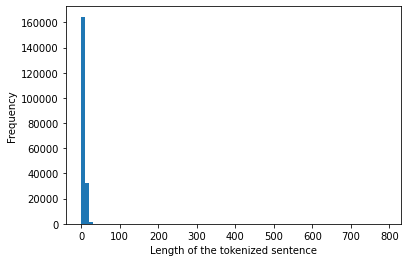

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# check the length distribution of the list with x ticks divided by 10 tokens
plt.hist(tokenized_length, bins=np.arange(0, max(tokenized_length)+1, 10))
print(max(tokenized_length)+1)
plt.xlabel("Length of the tokenized sentence")
plt.ylabel("Frequency")
plt.show()

In [12]:
# 토큰 50개 넘는 애들은 제거

In [13]:
tokenizer_input_ids.sort(key=lambda x: len(x))
while len(tokenizer_input_ids[-1]) >= 50:
    tokenizer_input_ids.pop()

In [14]:
print(len(tokenizer_input_ids[-1]))
tokenizer_input_ids[-1]

49


[9815,
 14778,
 18896,
 443,
 739,
 27797,
 18896,
 443,
 739,
 27797,
 18896,
 443,
 739,
 27797,
 33287,
 411,
 420,
 15369,
 421,
 427,
 424,
 10403,
 431,
 411,
 425,
 11045,
 411,
 9772,
 424,
 411,
 9707,
 411,
 407,
 47717,
 9924,
 35548,
 411,
 408,
 424,
 424,
 424,
 10445,
 31175,
 22068,
 426,
 22068,
 426,
 22068,
 426]

In [15]:
tokenized_length = [len(item) for item in tokenizer_input_ids]
tokenized_length[:5]

[1, 1, 1, 1, 1]

50


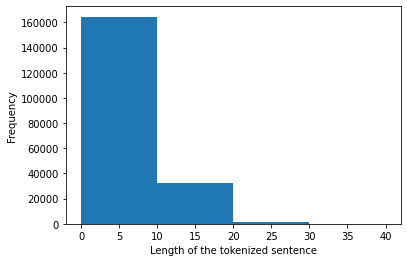

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# check the length distribution of the list with x ticks divided by 10 tokens
plt.hist(tokenized_length, bins=np.arange(0, max(tokenized_length)+1, 10))
print(max(tokenized_length)+1)
plt.xlabel("Length of the tokenized sentence")
plt.ylabel("Frequency")
plt.show()

In [17]:
def load_dataset(file_path, tokenizer, block_size=128):
    dataset = TextDataset(tokenizer=tokenizer,
                         file_path=file_path,
                         block_size=block_size,
                         )
    return dataset

def load_data_collator(tokenizer, mlm=False):
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                   mlm=mlm)
    return data_collator

In [18]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# 구글링 하면 다들 이 코드를 쓰지만
# tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2")
# model = GPT2LMHeadModel.from_pretrained("skt/kogpt2-base-v2")

# 허깅페이스 공식 사이트에는 이 코드로 나와서 이걸 사용
# tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2", padding='max_length',
#                                           max_len = 100,
#                                           add_special_tokens = True, 
#                                           return_tensors="pt",
#                                           truncation = True)
# model = AutoModelForCausalLM.from_pretrained("skt/kogpt2-base-v2")

In [32]:
model = AutoModelForCausalLM.from_pretrained("skt/kogpt2-base-v2")

def train(train_file_path, model_name, output_dir, overwrite_output_dir, per_device_train_batch_size, num_train_epochs, save_step, tokenizer):
    train_dataset = load_dataset(train_file_path, tokenizer)
    data_collator = load_data_collator(tokenizer)
    
    tokenizer.save_pretrained(output_dir, legacy_format=False)
    
#     model = AutoModelForCausalLM.from_pretrained("skt/kogpt2-base-v2")
    model.save_pretrained(output_dir)
    
    training_args = TrainingArguments(output_dir=output_dir,
                                     overwrite_output_dir=overwrite_output_dir,
                                     per_device_train_batch_size=per_device_train_batch_size,
                                     num_train_epochs=num_train_epochs)

    trainer = Trainer(model=model,
                     args=training_args,
                     data_collator=data_collator,
                     train_dataset=train_dataset)
    
    trainer.train()
    trainer.save_model()
    
train_file_path = "test_data.txt"
model_name = "skt/kogpt2-base-v2"
output_dir = "./models2"
overwrite_output_dir = False
per_device_train_batch_size = 8
num_train_epochs = 5.0
save_step = 500

train(train_file_path=train_file_path,
     model_name=model_name,
     output_dir=output_dir,
     overwrite_output_dir=overwrite_output_dir,
     per_device_train_batch_size=per_device_train_batch_size,
     num_train_epochs=num_train_epochs,
     save_step=save_step,
     tokenizer=tokenizer)

loading configuration file https://huggingface.co/skt/kogpt2-base-v2/resolve/main/config.json from cache at /home/work/.cache/huggingface/transformers/13bb826cf24517d7849a701e02452715a67c5e560142be3d4735442b2a545809.6b384eec6effdd44287f67715cd55bd0dff2cf846d843b932b43ba7b632b8b1e
Model config GPT2Config {
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 0,
  "created_date": "2021-04-28",
  "embd_pdrop": 0.1,
  "eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "license": "CC-BY-NC-SA 4.0",
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 3,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_a

Step,Training Loss
500,4.207100
1000,4.072100
1500,4.020200
2000,3.820500
2500,3.764500
3000,3.761800
3500,3.638600
4000,3.541900
4500,3.550500
5000,3.502600


Saving model checkpoint to ./models2/checkpoint-500
Configuration saved in ./models2/checkpoint-500/config.json
Model weights saved in ./models2/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./models2/checkpoint-1000
Configuration saved in ./models2/checkpoint-1000/config.json
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Model weights saved in ./models2/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./models2/checkpoint-1500
Configuration saved in ./models2/checkpoint-1500/config.json
/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them i

In [34]:
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel

def load_model(model_path):
    model = AutoModelForCausalLM.from_pretrained(model_path)
    return model

def load_tokenizer(tokenizer_path):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    return tokenizer

def generate_text(sequence, k, max_length):
    model_path = "./models2"
    model = load_model(model_path)
    tokenizer = load_tokenizer(model_path)
    ids = tokenizer.encode(f"{sequence},", return_tensors="pt")
    final_outputs = model.generate(ids, do_sample=True, max_length=max_length,
                                  pad_token_id=model.config.pad_token_id,
                                  top_k=50,
                                  top_p=0.95)
    print(tokenizer.decode(final_outputs[0], skip_special_tokens=True))

In [21]:
sequence = "친구"
max_len = 42
print("input :" + sequence)
print("=" * 30)

for i in range(5):
    generate_text(sequence, max_len)
    print("=" * 30)

loading configuration file ./models2/config.json
Model config GPT2Config {
  "_name_or_path": "skt/kogpt2-base-v2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 0,
  "created_date": "2021-04-28",
  "embd_pdrop": 0.1,
  "eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "license": "CC-BY-NC-SA 4.0",
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 3,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation

input :친구


All model checkpoint weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the model checkpoint at ./models2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.
Didn't find file ./models2/vocab.json. We won't load it.
Didn't find file ./models2/merges.txt. We won't load it.
Didn't find file ./models2/added_tokens.json. We won't load it.
loading file None
loading file None
loading file ./models2/tokenizer.json
loading file None
loading file ./models2/special_tokens_map.json
loading file ./models2/tokenizer_config.json
loading configuration file ./models2/config.json
Model config GPT2Config {
  "_name_or_path": "skt/kogpt2-base-v2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 0,
 

친구, 힙합 클럽에서
지루하다며 울다 보면
그런 건 절대 못해 너란 놈은
난 괜찮아 내 삶의 주인이 되려 해
네 앞에선 


All model checkpoint weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the model checkpoint at ./models2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.
Didn't find file ./models2/vocab.json. We won't load it.
Didn't find file ./models2/merges.txt. We won't load it.
Didn't find file ./models2/added_tokens.json. We won't load it.
loading file None
loading file None
loading file ./models2/tokenizer.json
loading file None
loading file ./models2/special_tokens_map.json
loading file ./models2/tokenizer_config.json
loading configuration file ./models2/config.json
Model config GPT2Config {
  "_name_or_path": "skt/kogpt2-base-v2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 0,
 

친구,
오래 된 편지 한 장과
그댈 위한 노랠 불러 봅니다
Lets gets get set set
그대 나를 떠난다고 말하지 마오
아무


All model checkpoint weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the model checkpoint at ./models2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.
Didn't find file ./models2/vocab.json. We won't load it.
Didn't find file ./models2/merges.txt. We won't load it.
Didn't find file ./models2/added_tokens.json. We won't load it.
loading file None
loading file None
loading file ./models2/tokenizer.json
loading file None
loading file ./models2/special_tokens_map.json
loading file ./models2/tokenizer_config.json
loading configuration file ./models2/config.json
Model config GPT2Config {
  "_name_or_path": "skt/kogpt2-base-v2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 0,
 

친구,
내 곁을 떠나갔는데
우리 둘 만의 Dance
아무 생각이나 말고
그렇다고 내 삶이 끝나는 건 아니야
이제 네가 없는 세상이 낯설어



All model checkpoint weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the model checkpoint at ./models2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.
Didn't find file ./models2/vocab.json. We won't load it.
Didn't find file ./models2/merges.txt. We won't load it.
Didn't find file ./models2/added_tokens.json. We won't load it.
loading file None
loading file None
loading file ./models2/tokenizer.json
loading file None
loading file ./models2/special_tokens_map.json
loading file ./models2/tokenizer_config.json
loading configuration file ./models2/config.json
Model config GPT2Config {
  "_name_or_path": "skt/kogpt2-base-v2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 0,
 

친구, 아빠는 나의 사랑아빠는 나의 딸
내가 네가 아팠던 기억에
그런 놈들 있지 난 다 알아
when i fallin
난 너에게


All model checkpoint weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the model checkpoint at ./models2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.
Didn't find file ./models2/vocab.json. We won't load it.
Didn't find file ./models2/merges.txt. We won't load it.
Didn't find file ./models2/added_tokens.json. We won't load it.
loading file None
loading file None
loading file ./models2/tokenizer.json
loading file None
loading file ./models2/special_tokens_map.json
loading file ./models2/tokenizer_config.json


친구, Ye
사랑해줘서 고마워요
이번만큼은 나를 사랑해준거야
사랑해줘서 고마워
아프게 해 아무것도 아닌
또 너한테 또


In [35]:
def make_samhaengshi(input_letter, k, output_token_length):
    list_samhaengshi = []
    for one_letter in input_letter:
        list_decoded_sequences = generate_text(one_letter, k=k, max_length=output_token_length)
        list_samhaengshi.extend(list_decoded_sequences)
    return list_samhaengshi

make_samhaengshi(input_letter="가을잎", k=1, output_token_length=10)

loading configuration file ./models2/config.json
Model config GPT2Config {
  "_name_or_path": "skt/kogpt2-base-v2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 0,
  "created_date": "2021-04-28",
  "embd_pdrop": 0.1,
  "eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "license": "CC-BY-NC-SA 4.0",
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 3,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation

가,
나를 보며 웃을 수 있어서



TypeError: 'NoneType' object is not iterable

In [31]:
def infer_sentence(input_sentence, k, output_token_length, model):

    # encode the sample sentence
    input_ids = tokenizer.encode(
        input_sentence, 
        add_special_tokens=False, 
        return_tensors="pt"
        )

    # decode the output sequence and print its outcome
    list_decoded_sequences = []
    while len(list_decoded_sequences) < k:
        # generate output sequence from the given encoded input sequence
        output_sequences = model.generate(
            input_ids=input_ids.to(device), 
            do_sample=True, 
            max_length=output_token_length, 
            num_return_sequences=k
            )

        for index, generated_sequence in enumerate(output_sequences):
            generated_sequence = generated_sequence.tolist()
            # remove padding from the generated sequence
            generated_sequence = generated_sequence[:generated_sequence.index(tokenizer.pad_token_id)]
            decoded_sequence = tokenizer.decode(generated_sequence, clean_up_tokenization_spaces=True)
            # print(f"{index} : {decoded_sequence}")
            list_decoded_sequences.append(decoded_sequence)
        list_decoded_sequences = list(set(list_decoded_sequences))
    
    return list_decoded_sequences

input_sentence = "너는 나의"
print(f"Inferred sentences given '{input_sentence}'")
inferred_sentences = infer_sentence(input_sentence, k=10, output_token_length=42, model=model)
inferred_sentences

Inferred sentences given '너는 나의'


NameError: name 'model' is not defined

# 여기부터 다른 내용

[참고 링크](https://github.com/snoop2head/KoGPT-Joong-2/blob/main/finetune_kogpt_trinity.ipynb)

In [ ]:
import os
import random
import torch
import pandas as pd
import numpy as np

ROOT_PATH = os.path.abspath(".")

In [ ]:
from datetime import datetime
from easydict import EasyDict

# Initialize configuration
CFG = EasyDict()

# Dataset Config as constants
CFG.DEBUG = False
CFG.num_workers = 4
CFG.train_batch_size = 16

# Train configuration
CFG.user_name = "snoop2head"
today = datetime.now().strftime("%m%d_%H:%M")
CFG.file_base_name = f"{CFG.user_name}_{today}"
CFG.model_dir = "skt/ko-gpt-trinity-1.2B-v0.5" # designate the model's name registered on huggingface: https://huggingface.co/skt/ko-gpt-trinity-1.2B-v0.5
CFG.max_token_length = 42
CFG.learning_rate = 5e-5
CFG.weight_decay = 1e-2 # https://paperswithcode.com/method/weight-decay and https://github.com/clovaai/AdamP

# training steps configurations
CFG.save_steps = 500
CFG.early_stopping_patience = 5
CFG.warmup_steps = 500
CFG.logging_steps = 100
CFG.evaluation_strategy = 'epoch'
CFG.evaluation_steps = 500

# Directory configuration
CFG.result_dir = os.path.join(ROOT_PATH, "results")
CFG.saved_model_dir = os.path.join(ROOT_PATH, "best_models")
CFG.logging_dir = os.path.join(ROOT_PATH, "logs")
CFG.baseline_dir = os.path.join(ROOT_PATH, 'baseline-code')

print(CFG)

In [ ]:
# read txt file from line by line
def read_txt(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    return lines

# make sampling function from the list
def sampling(list_lines:list, n:int) -> list:
    # sampling
    list_lines = np.random.choice(list_lines, n)
    list_lines = list(list_lines)
    return list_lines

In [ ]:
# read dataset from poetic_sentences_kor.txt
path = os.path.join("test_data.txt")
list_loaded = read_txt(path)
print("total dataset length:", len(list_loaded))

In [ ]:
# get proportion of sentences where length is between 1 and 52
min_char_length = 5
max_char_length = 52
list_to_use = list(filter(lambda x: len(x) > min_char_length and len(x) < max_char_length, list_loaded))

print(f"Length of dataset that is in between {min_char_length} and {max_char_length} is" , len(list_to_use))
print(f"This is {round(len(list_to_use) / len(list_loaded) * 100, 2)} % of total dataset")

n = 20
print(f"Below are {n} samples of data to use")
sampling(list_to_use, n)

In [ ]:
import re

stopwords = []

# make post_process function
def post_process(list_lines:list, stopwords) -> list:
    # remove \n
    removed_lines = [line.strip() for line in list_lines]

    # filter stopwords from the line item in list_lines using regex
    if len(stopwords) > 0:
        removed_lines = []
        for line in list_lines:
            for stopword in stopwords:
                line = re.sub(stopword, '', line)
            removed_lines.append(line)

    # remove newlines
    removed_lines = [sentence.replace('\n', '') for sentence in removed_lines]

    # strip whitespace
    removed_lines = [sentence.strip() for sentence in removed_lines]

    # remove one letter items
    removed_lines = [sentence for sentence in removed_lines if len(sentence) > 1]

    return removed_lines

In [ ]:
list_post_processed = post_process(list_to_use, stopwords)
print(len(list_post_processed))

n = 10
sampling(list_post_processed, n)

In [ ]:
from transformers import GPT2Tokenizer, PreTrainedTokenizerFast

# Load the Tokenizer: "Fast" means that the tokenizer code is written in Rust Lang
tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")

In [ ]:
# get the length of the individual items in tokenized input_ids
tokenized_input_ids = tokenizer(list_post_processed).input_ids
tokenized_length = [len(item) for item in tokenized_input_ids]

In [ ]:
from transformers import GPT2Config

# set config and override with custom configuration
config = GPT2Config.from_pretrained(CFG.model_dir)
config

In [ ]:
import torch

# move the model to device
if torch.cuda.is_available() and CFG.DEBUG == False:
    device = torch.device("cuda:0")
elif CFG.DEBUG == True:
    device = torch.device("cpu")

print(f"current device that is training on: {device}")
model = model.to(device)
model.train()

In [ ]:
!nvidia-smi

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    """ CustomDataset class for poetic sentences """
    def __init__(self, list_dataset, tokenizer):

        self.list_dataset = list_dataset
        self.tokenizer = tokenizer
        self.tokenized_sentences = self.tokenizer(
            list_dataset,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=CFG.max_token_length,
            add_special_tokens=True,
            return_token_type_ids=False,
            )

    def __getitem__(self, idx):
        encoded_dict = {key: val[idx] for key, val in self.tokenized_sentences.items()}
        encoded_dict["labels"] = encoded_dict["input_ids"].clone() # gpt has same labels as input_ids: https://github.com/huggingface/notebooks/blob/master/examples/language_modeling.ipynb
        return encoded_dict

    def __len__(self):
        return len(self.list_dataset)

In [ ]:
list_post_processed

In [ ]:
kor_poetic_dataset = CustomDataset(list_post_processed, tokenizer)
kor_eval_dataset_for_debugging = CustomDataset(list_post_processed[:100], tokenizer) # small dataset for debugging purpose
print(len(kor_poetic_dataset))